In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [13]:
# Define the dataset directory
dataset_dir = dataset

In [14]:
import cv2
# Function to get image file paths and corresponding labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for sub_dir in os.listdir(class_dir):
                sub_dir_path = os.path.join(class_dir, sub_dir)
                if os.path.isdir(sub_dir_path):
                    for img_name in os.listdir(sub_dir_path):
                        img_path = os.path.join(sub_dir_path, img_name)
                        if os.path.isfile(img_path):
                            img = cv2.imread(img_path)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (128, 128))
                            image_paths.append(img/255.0)
                            labels.append(label)
    
    return np.array(image_paths), labels, class_names

In [15]:
# Get paths and labels for the data
image_paths, labels, class_names = get_image_paths_and_labels(dataset_dir)
labels = np.array(labels)

In [16]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Load and preprocess images
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image.numpy(), label

In [18]:
# # Create a list of (image, label) tuples
# data = [load_image(path, label) for path, label in zip(image_paths, labels)]

In [19]:
# Separate images and labels
images, labels = image_paths, labels
# images = np.array(images)
labels = np.array(labels)

In [20]:
# Initialize Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
tf.experimental.numpy.experimental_enable_numpy_behavior()
# Prepare to collect metrics
val_accuracies = []
all_labels = []
all_predictions = []

for train_index, val_index in kf.split(images, labels):
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Create ImageDataGenerators for training and validation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator()
    
    # Create training and validation generators
    train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
    
    # Load the ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes: caries, gingivitis, wsl

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        class_weight=class_weights,
        callbacks=[checkpoint]
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    val_accuracies.append(val_accuracy)

    # Generate predictions for the validation set
    val_pred_probs = model.predict(val_generator)
    val_preds = np.argmax(val_pred_probs, axis=1)
    
    # Collect labels and predictions for confusion matrix
    all_labels.extend(val_labels)
    all_predictions.extend(val_preds)

Epoch 1/50


I0000 00:00:1716826653.071051  275526 service.cc:145] XLA service 0x7cc6200025d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716826653.071070  275526 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1716826654.277862  275572 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5665', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1716826654.398677  275571 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5672', 460 bytes spill stores, 348 bytes spill loads

I0000 00:00:1716826654.905811  275577 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5848', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716826655.038747  275575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3478 - loss: 1.3074

I0000 00:00:1716826656.960474  275526 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1716826659.085186  275693 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1702', 460 bytes spill stores, 348 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3478 - loss: 1.3074 - val_accuracy: 0.3333 - val_loss: 1.1110
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4348 - loss: 1.1127 - val_accuracy: 0.3333 - val_loss: 1.2577
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4348 - loss: 1.2512 - val_accuracy: 0.3333 - val_loss: 1.1709
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4348 - loss: 1.1654 - val_accuracy: 0.3333 - val_loss: 1.1192
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2174 - loss: 1.1174 - val_accuracy: 0.1667 - val_loss: 1.1268
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2174 - loss: 1.1235 - val_accuracy: 0.3333 - val_loss: 1.1683
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3478 - loss: 1.1563 - val_accuracy: 0.3333 - val_loss: 1.1711
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3478 - loss: 1.1585 - val_accuracy: 0.3333 - val_loss: 1.1310
Epoch 9/50

I0000 00:00:1716826718.459380  281678 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5679', 460 bytes spill stores, 348 bytes spill loads

I0000 00:00:1716826718.671611  281679 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5665', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1716826718.725933  281682 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5679', 952 bytes spill stores, 620 bytes spill loads

I0000 00:00:1716826718.879920  281676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5848', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716826718.888437  281673 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5848', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1716826719.356

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2500 - loss: 1.2087

I0000 00:00:1716826723.305977  281795 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1702', 460 bytes spill stores, 348 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.2500 - loss: 1.2087 - val_accuracy: 0.4000 - val_loss: 1.0581
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3333 - loss: 1.1847 - val_accuracy: 0.4000 - val_loss: 1.0808
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 0.4167 - loss: 1.2264 - val_accuracy: 0.4000 - val_loss: 1.0566
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4167 - loss: 1.1297 - val_accuracy: 0.2000 - val_loss: 1.1211
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2917 - loss: 1.1010 - val_accuracy: 0.2000 - val_loss: 1.2384
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2500 - loss: 1.1508 - val_accuracy: 0.2000 - val_loss: 1.2592
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2500 - loss: 1.1614 - val_accuracy: 0.2000 - val_loss: 1.1796
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.2500 - loss: 1.1203 - val_accuracy: 0.4000 - val_loss: 1.0982
Epoch 9/

In [22]:
# Print average validation accuracy
print(f'Average validation accuracy: {np.mean(val_accuracies):.2f}')

Average validation accuracy: 0.21


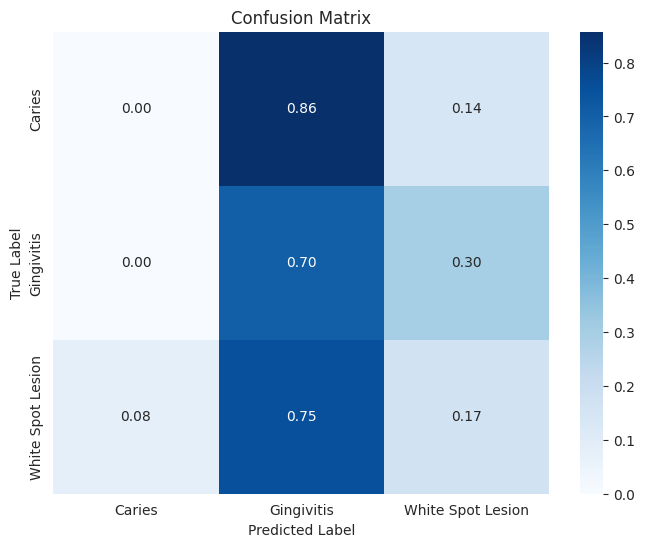

In [23]:
# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
# Print classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

                   precision    recall  f1-score   support

           Caries       0.00      0.00      0.00         7
       Gingivitis       0.32      0.70      0.44        10
White Spot Lesion       0.33      0.17      0.22        12

         accuracy                           0.31        29
        macro avg       0.22      0.29      0.22        29
     weighted avg       0.25      0.31      0.24        29



In [25]:
# Plotting the training history (optional)
import json

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/resnet_history.json"
    json.dump(history_dict, open(history_file, 'w'))

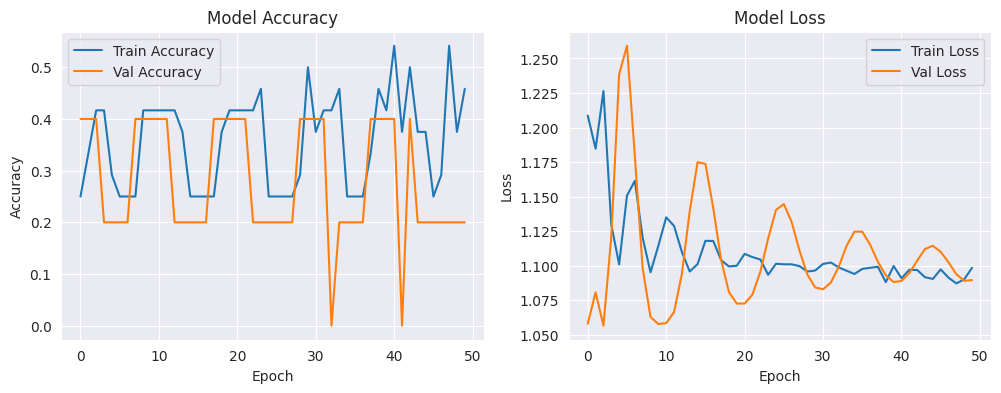

In [26]:
plot_training_history(history)